# Image Clustering
This notebook clusters the dataset images using the pretrained DinoV2 model. The model is used to extract features from the images, which are then clustered using KMeans.

### Imports

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import numpy as np  
import plotly.express as px

from config import Config

### Load config

In [2]:
cfg = Config()

### Feature Extraction

In [3]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True)
model.cuda()
model

Using cache found in C:\Users\vilyi/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\vilyi/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
C:\Users\vilyi/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
C:\Users\vilyi/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [4]:
transform = transforms.Compose([
    transforms.Resize(int(cfg.img_size * 1.1)),
    transforms.CenterCrop(cfg.img_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Iterate over all images and extract features
outputs = []
for p in tqdm(os.listdir(cfg.datapath), desc='Extracting features', unit='images'):

    img = Image.open(os.path.join(cfg.datapath, p))
    img = transform(img).unsqueeze(0).cuda()
    with torch.no_grad():
        output = model(img)
        output = output.squeeze(0)
        output = output.cpu().numpy()
        outputs.append(output)

Extracting features:   0%|          | 0/5399 [00:00<?, ?images/s]A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Extracting features: 100%|██████████| 5399/5399 [01:32<00:00, 58.07images/s]


### How Many Clusters?

In [5]:
kmax = 250
sil = []
K = range(2, kmax+1)
for k in tqdm(K, desc='Finding best k', unit='k'):
  kmeans = KMeans(n_clusters = k, n_init='auto').fit(outputs)
  labels = kmeans.labels_
  sil.append(silhouette_score(outputs, labels, metric = 'cosine'))


best_k = sil.index(max(sil)) + 2 # offset due to k in [2, 250]
best_k

Finding best k: 100%|██████████| 249/249 [01:19<00:00,  3.15k/s]


94

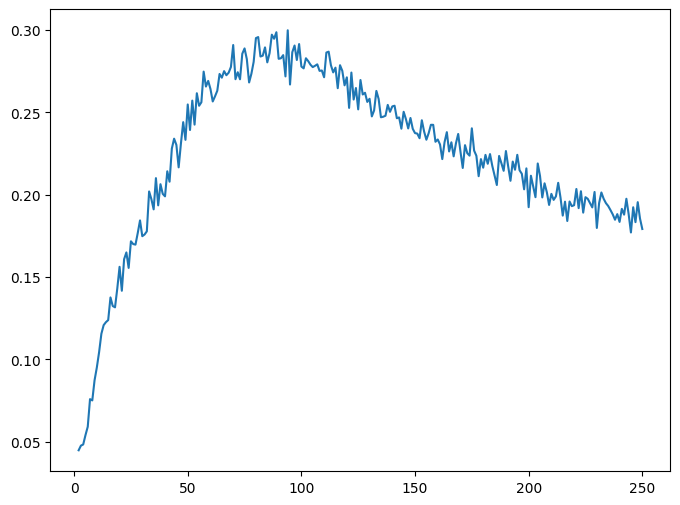

In [6]:
# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(K, sil)

## KMeans Clustering with best `k`

In [7]:
kmeans = KMeans(n_clusters=best_k, n_init='auto')
labels = kmeans.fit_predict(outputs)

### Visualize Clusters with t-SNE

In [8]:
# 2D t-SNE plot
tsne = TSNE(n_components=2, random_state=0)
X = tsne.fit_transform(np.array(outputs))
df = pd.DataFrame(X, columns=['x', 'y'])
df['label'] = labels

fig = px.scatter(df, x='x', y='y', color='label', color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y'), showlegend=False,    xaxis=dict(visible=False), yaxis=dict(visible=False),)
fig.show()

In [ ]:
# 3D t-SNE plot
tsne = TSNE(n_components=3, random_state=0)
X = tsne.fit_transform(np.array(outputs))
df = pd.DataFrame(X, columns=['x', 'y', 'z'])
df['label'] = labels


In [ ]:
import plotly.graph_objects as go
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', color_discrete_map="identity", template='plotly_white')
fig.update_traces(marker=dict(size=2))
fig.update_layout(scene = dict(showlegend=False, xaxis=dict(visible=False), yaxis=dict(visible=False),
        ))

x_eye = -1.25
y_eye = 2
z_eye = 0.5
fig.update_layout(
         title='Animation Test',
         width=1000,
         height=1000,
         scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
         updatemenus=[dict(type='buttons',
                  showactive=False,
                  y=1,
                  x=0.8,
                  xanchor='left',
                  yanchor='bottom',
                  pad=dict(t=45, r=10),
                  buttons=[dict(label='Play',
                                 method='animate',
                                 args=[None, dict(frame=dict(duration=5, redraw=True), 
                                                             transition=dict(duration=0),
                                                             fromcurrent=True,
                                                             mode='immediate'
                                                            )]
                                            )
                                      ]
                              )
                        ]
)

def rotate_z(x, y, z, theta):
    w = x+1j*y
    return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

frames=[]
for t in np.arange(0, 6.26, 0.1):
    xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
    frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
fig.frames=frames

fig.show()

### Concluding Notes
The best determined number of clusters is deviating from the number of classes in the dataset (90). This could be due to the fact that the DinoV2 model was trained on a different dataset, which might have different features. The model might not be able to extract the features that are needed to cluster the images by their classes. Furthermore, there could be unsuitable samples in the dataset, which are not representative for their class. 